In [210]:
# Download tweets.
import numpy as np
import pickle
import math
import sklearn.metrics # Area Under the ROC calculations.
import cloudpickle as cp
import matplotlib.pylab as plt # Plotting
from urllib.request import urlopen
lst_donald_trump_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/DonaldTrumpTweets.pickle"))
lst_joe_biden_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/JoeBidenTweets.pickle"))

In [211]:
class char_ngram():
  def __init__(self):
    '''Initialize vocabulary and parameters of model.'''
    # Special tokens: ^==start, $==stop.
    self.tokens = '^$ abcdefghijklmnopqrstuvwxyz'
    #              01234567890123456789012345678
    # Create map from token to index (integer).
    self.token_idx = dict([(t,i) for (i,t) in enumerate(self.tokens)]) 
    # Initialize matrix of transition probabilities to uniform distribution.
    n = len(self.tokens)
    self.transitions = np.ones((n,n), dtype='float')
    self.transitionsCount = np.zeros((n,n), dtype='float')
    return
  
  def fit(self, data):
    '''
    Learn transition probabilities from data.
    Input:
        data = list of strings to train on.
    '''
    transitionsTotalCount = 0
    tweetCount = 0
    newDict = { self.tokens[i] : i for i in range(0, len(self.tokens) ) }
    for tweet in data[0:-1000]:
      tweetCount += 1
      tweet = self.tokenize(tweet)
      for i in range(len(tweet) -1):
        transitionsTotalCount += 1
        self.transitions[newDict[tweet[i]], newDict[tweet[i+1]]] += 1
    # self.transitionsCount[self.transitionsCount == 0] = 1 - use to replace zero elements
    for i in range(self.transitions.shape[0]):
      self.transitions[i] = self.transitions[i] / np.sum(self.transitions[i,:])
      
    
    
    

  def generate(self, N, prompt=None):
    '''
    Generate a random string of length N starting from prompt.
      Input:
        prompt (optional): a string that should begin the tweet, e.g. 'covid'. 
    Returns:
        tweet = A fake tweet (string).
    '''

    string1 = prompt

    newDict = { self.tokens[i] : i for i in range(0, len(self.tokens) ) }

    for i in range(N):
      prev_token = newDict[string1[-1]]
      row = self.transitions[prev_token,:]
      indices = row.nonzero()[0]
      if indices is not None and len(indices) > 0:
        probs = row[indices]
        # Randomly sample from choices with non-zero probs.
        next_token = np.random.choice(indices, p=probs)
      else:
        # Just append a common word. There are obviously better solutions.
        next_token = "a"
      # Append the token to the generated sequence.
      string1 = string1 + self.tokens[next_token]

    # print(string1)

    return string1


  def tokenize(self, string):
    '''
    A simple character tokenization:
    1) Leading and ending spaces are removed.
    2) All letters converted to lowercase.
    3) All characters other than a-z and space are ignored.
    Input:
        string
    Returns: 
        tokens = list of characters (python strings of length 1).
    '''
    tokens = []
    sanitized = string.lower().strip().replace('^','')
    for char in sanitized:
      if char in self.tokens:
        tokens.append(char)
    # Add start and stop tokens.
    tokens = ['^'] + tokens + ['$']
    return tokens

  def evaluate(self, data):
    '''
    Calculate the mean log probability of the character transitions.
    We use mean because then we have a fair comparison between two sequences
    of different lengths.
    Input:
        data = string or list of strings to train on.
    Returns:
        mean_logp = (float) average of the log2 probability of the transitions in the data.
    '''
    if type(data) is str:
      data = [data] # Interpret as list of length 1.
    logp_sum = 0
    count = 0
    for string in data:
      s = self.tokenize(string)
      for c1,c2 in zip(s[:-1], s[1:]):
        p = self.transitions[self.token_idx[c1], self.token_idx[c2]]
        if p == 0:
          raise Exception('The model thinks this sequence is impossible'
                          '! Regularize the transition probabilities.')
        logp_sum += np.log2(p) 
        count += 1
    mean_logp = logp_sum / count
    return mean_logp



--Start--Trump-vs-Biden--tweet-predictions--


----------------------------------------------------
Generated trump tweet of size  30  and prompt  napa  :
napa tow toume thecant f amon  frt 
----------------------------------------------------


----------------------------------------------------
Generated Biden tweet of size  30  and prompt  sonoma  :
sonoma il antone ge s cothe s yjoe bo
----------------------------------------------------


----------------------------------------------------
Generated trump tweet of size  30  and prompt  san francisco  :
san francisco gisstcouppref rrfoller oy ouma
----------------------------------------------------


----------------------------------------------------
Generated Biden tweet of size  30  and prompt  new york  :
new york ttthequrihor ice m o meegeero 
----------------------------------------------------

----------------------------------------------------
Evaluate last string in Trump data using Mean Log Likelihood
Last string:


Text(0, 0.5, 'True Positive Rate')

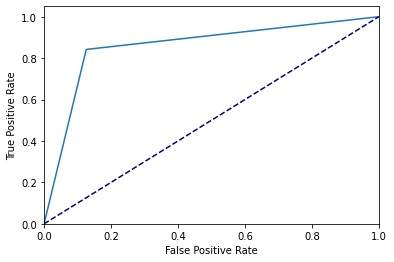

In [212]:
gramTrump = char_ngram()
gramTrump.fit(lst_donald_trump_tweets)
gramBiden = char_ngram()
gramBiden.fit(lst_joe_biden_tweets)

print("\n--Start--Trump-vs-Biden--tweet-predictions--")

def trumpTweets(prompt):
  #---------------------TRUMP---------------------------------------
  print("\n")
  tweetSize = 30
  tweetPrompt = prompt
  tweet = gramTrump.generate(tweetSize, tweetPrompt)
  print("----------------------------------------------------")
  print("Generated trump tweet of size ", tweetSize, " and prompt ", tweetPrompt, ":")
  print(tweet)
  print("----------------------------------------------------")
  

def bidenTweets(prompt):
  #-------------BIDEN--------------------------------------------
  print("\n")
  tweetSize = 30
  tweetPrompt = prompt
  tweet = gramBiden.generate(tweetSize, tweetPrompt)
  print("----------------------------------------------------")
  print("Generated Biden tweet of size ", tweetSize, " and prompt ", tweetPrompt, ":")
  print(tweet)
  print("----------------------------------------------------")
  

trumpTweets("napa ")
bidenTweets("sonoma ")
trumpTweets("san francisco ")
bidenTweets("new york ")


#-----------------EVALUATE BIDEN---------------------
print()
print("----------------------------------------------------")
print("Evaluate last string in Trump data using Mean Log Likelihood" )
print("Last string:\n", lst_donald_trump_tweets[-1])
bidenLikelihood = gramBiden.evaluate(lst_donald_trump_tweets[-1])
print("Mean_logp = ", bidenLikelihood)
print("----------------------------------------------------")

#-----------------EVALUATE TRUMP---------------------
print()
print("----------------------------------------------------")
print("\nEvaluate last string in Trump data using Mean Log Likelihood" )
print("Last string:\n", lst_donald_trump_tweets[-1])

trumpLikelihood = gramTrump.evaluate(lst_donald_trump_tweets[-1])
print("Mean_logp = ", trumpLikelihood)
print("----------------------------------------------------\n")

#-----------------BAYES RULE---------------------
print("----------------------------------------------------")
print("Using bayes rules to pick who wrote the last tweet in trumps data")
likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))
print("likelihoodTrump = ", likelihoodTrumpGivenTweet)
likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))
print("likelihoodBiden = ", likelihoodBidenGivenTweet)

#-----------------TEST SET ROC---------------------
testTrump = lst_donald_trump_tweets[-1000:]
testBiden = lst_joe_biden_tweets[-1000:]

countFP = 0 #False Positive Count
countTP = 0 #True Positive Count
countFN = 0 #False Negative Count
countTN = 0 #True Negative count

#---Matrix for roc curve sklearn-----
rocMatrix = np.zeros(shape=(2000, 2))
rocMatrix[:1000,0] = 1
rocMatrix[1000:,0] = 0

trumpTestCount = 0
for tweet in testTrump:
  trumpLikelihood = gramTrump.evaluate(tweet)
  bidenLikelihood = gramBiden.evaluate(tweet)
  likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))
  likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))

  if likelihoodTrumpGivenTweet <= .5:
    countFN += 1
  if likelihoodTrumpGivenTweet > .5:
    rocMatrix[trumpTestCount, 1] = 1
    countTP += 1
  if likelihoodBidenGivenTweet <= .5:
    countTN += 1
  if likelihoodBidenGivenTweet > .5:
    countFP += 1

  trumpTestCount += 1

bidenTestCount = 1000
for tweet in testBiden:
  bidenLikelihood = gramBiden.evaluate(tweet)
  trumpLikelihood = gramTrump.evaluate(tweet)
  likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))
  likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))

  if likelihoodTrumpGivenTweet > .5:
    rocMatrix[bidenTestCount,1] = 1
    countFP += 1
  if likelihoodTrumpGivenTweet <= .5:
    countTN += 1
  if likelihoodBidenGivenTweet > .5:
    countTP += 1
  if likelihoodBidenGivenTweet <= .5:
    countFN += 1 

  bidenTestCount += 1


auroc = (countTP + countTN) / (countTP + countFP + countTN + countFN)

print("\n------ROC----------")
print("Accuracy = ", auroc)

# fpr = countFP / (countFP + countTN)
# tpr = countTP / (countTP + countFN)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(rocMatrix[:,0], rocMatrix[:,1])
print("fpr and tpr = ", fpr, " - ", tpr)
# Plot ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')



It seems to me that trumpLike tweets have a harsher pronounciation, while bidenLike tweets seem soft.

bidenLike tweets seems to use more of the characters: s, o, w, n

trumpLike tweets seem to use more of the characters: a, t, g, h